In [1]:
import numpy as np  # numpy backend
import pygmtools as pygm
import matplotlib.pyplot as plt  # for plotting
from matplotlib.patches import ConnectionPatch  # for plotting matching result
import networkx as nx  # for plotting graphs

pygm.set_backend("numpy")  # set default backend for pygmtools
np.random.seed(1)  # fix random seed

In [2]:
plt.rcParams["font.family"] = "PingFang HK"

In [3]:
num_nodes = 5
X_gt = np.zeros((num_nodes, num_nodes))
X_gt[np.arange(0, num_nodes, dtype=np.int64), np.random.permutation(num_nodes)] = 1
A1 = np.random.rand(num_nodes, num_nodes)
A1 = (A1 + A1.T > 1.0) * (A1 + A1.T) / 2
np.fill_diagonal(A1, 0)
A2 = np.matmul(np.matmul(X_gt.T, A1), X_gt)
n1 = np.array([num_nodes])
n2 = np.array([num_nodes])


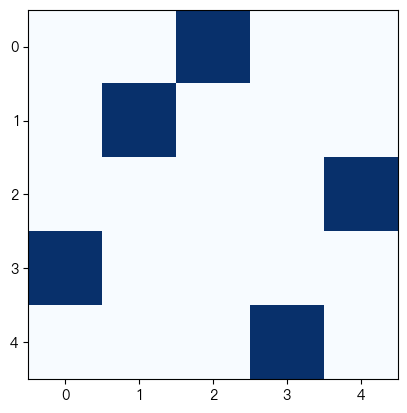

In [4]:
plt.imshow(X_gt, cmap='Blues')

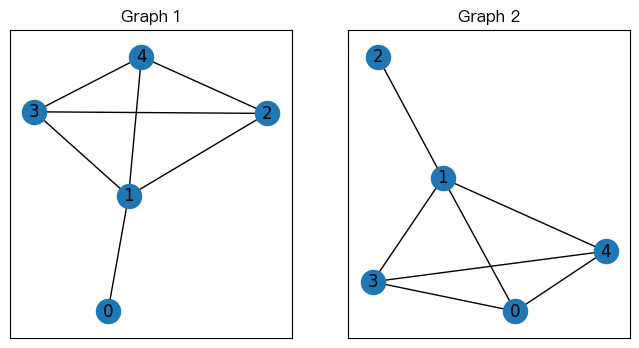

In [5]:
plt.figure(figsize=(8, 4))
G1 = nx.from_numpy_array(A1)
G2 = nx.from_numpy_array(A2)
pos1 = nx.spring_layout(G1)
pos2 = nx.spring_layout(G2)
plt.subplot(1, 2, 1)
plt.title("Graph 1")
nx.draw_networkx(G1, pos=pos1)
plt.subplot(1, 2, 2)
plt.title("Graph 2")
nx.draw_networkx(G2, pos=pos2)

In [6]:
conn1, edge1 = pygm.utils.dense_to_sparse(A1)
conn2, edge2 = pygm.utils.dense_to_sparse(A2)
import functools

gaussian_aff = functools.partial(
    pygm.utils.gaussian_aff_fn, sigma=0.1
)  # set affinity function
K = pygm.utils.build_aff_mat(
    None, edge1, conn1, None, edge2, conn2, n1, None, n2, None, edge_aff_fn=gaussian_aff
)

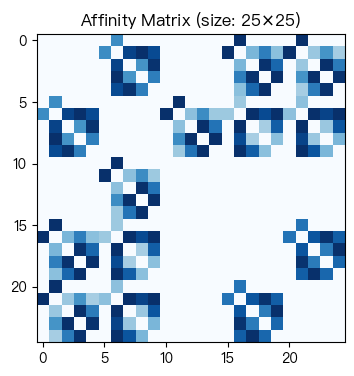

In [7]:
plt.figure(figsize=(4, 4))
plt.title(f'Affinity Matrix (size: {K.shape[0]}$\\times${K.shape[1]})')
plt.imshow(K, cmap='Blues')

In [24]:
K

array([[0.        , 0.        , 0.        , 0.        , 0.96775571,
        1.        , 0.        , 0.88124014, 0.74980419],
       [0.        , 0.        , 0.        , 0.96775571, 0.        ,
        0.74980419, 0.88124014, 0.        , 1.        ],
       [0.        , 0.        , 0.        , 1.        , 0.74980419,
        0.        , 0.74980419, 1.        , 0.        ],
       [0.        , 0.96775571, 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.96775571],
       [0.96775571, 0.        , 0.74980419, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.88124014],
       [1.        , 0.74980419, 0.        , 0.        , 0.        ,
        0.        , 0.96775571, 0.88124014, 0.        ],
       [0.        , 0.88124014, 0.74980419, 0.        , 1.        ,
        0.96775571, 0.        , 0.        , 0.        ],
       [0.88124014, 0.        , 1.        , 1.        , 0.        ,
        0.88124014, 0.        , 0.        , 0.        ],


In [25]:
np.where(K != 0)[0].shape

(36,)

In [12]:
X = pygm.sm(K, n1, n2)
X

array([[0.09651582, 0.05265988, 0.0433186 , 0.0696051 , 0.07206711],
       [0.20856331, 0.31837316, 0.05265988, 0.25543429, 0.24873962],
       [0.23245022, 0.24873962, 0.07206711, 0.23883848, 0.2378871 ],
       [0.26305723, 0.20856331, 0.09651582, 0.2295326 , 0.23245022],
       [0.2295326 , 0.25543429, 0.0696051 , 0.24075114, 0.23883848]])

In [30]:
np.sum(X, axis=0)

array([0.33279574, 0.33375776, 0.33344651])

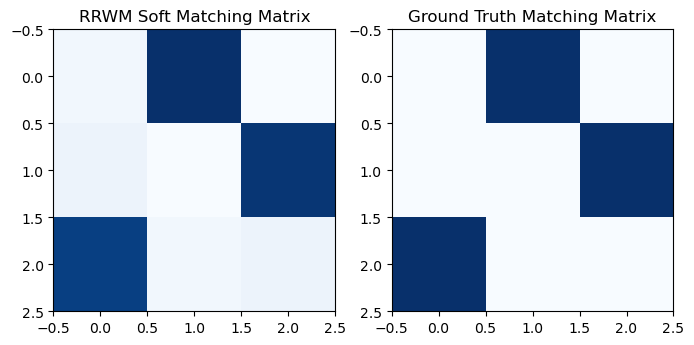

In [31]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('RRWM Soft Matching Matrix')
plt.imshow(X, cmap='Blues')
plt.subplot(1, 2, 2)
plt.title('Ground Truth Matching Matrix')
plt.imshow(X_gt, cmap='Blues')

In [17]:
X = pygm.hungarian(X)

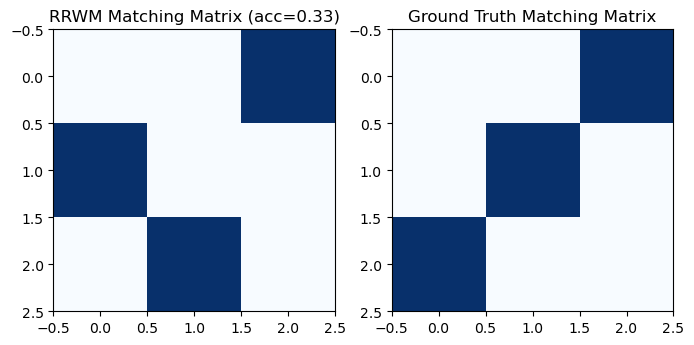

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f'RRWM Matching Matrix (acc={(X * X_gt).sum() / X_gt.sum():.2f})')
plt.imshow(X, cmap='Blues')
plt.subplot(1, 2, 2)
plt.title('Ground Truth Matching Matrix')
plt.imshow(X_gt, cmap='Blues')

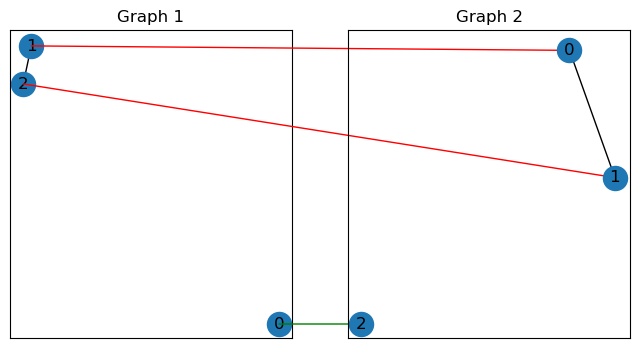

In [19]:
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 2, 1)
plt.title('Graph 1')
nx.draw_networkx(G1, pos=pos1)
ax2 = plt.subplot(1, 2, 2)
plt.title('Graph 2')
nx.draw_networkx(G2, pos=pos2)
for i in range(num_nodes):
    j = np.argmax(X[i]).item()
    con = ConnectionPatch(xyA=pos1[i], xyB=pos2[j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="green" if X_gt[i, j] else "red")
    plt.gca().add_artist(con)

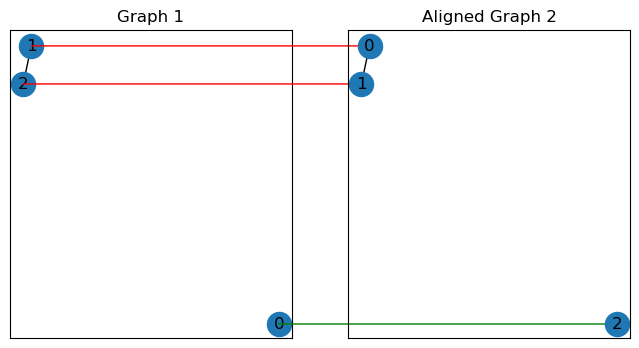

In [20]:
align_A2 = np.matmul(np.matmul(X, A2), X.T)
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 2, 1)
plt.title('Graph 1')
nx.draw_networkx(G1, pos=pos1)
ax2 = plt.subplot(1, 2, 2)
plt.title('Aligned Graph 2')
align_pos2 = {}
for i in range(num_nodes):
    j = np.argmax(X[i]).item()
    align_pos2[j] = pos1[i]
    con = ConnectionPatch(xyA=pos1[i], xyB=align_pos2[j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="green" if X_gt[i, j] else "red")
    plt.gca().add_artist(con)
nx.draw_networkx(G2, pos=align_pos2)